<a href="https://colab.research.google.com/github/jere1882/DL_IADS22/blob/main/RNN_ailrline_passenger_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# International Airline Passengers prediction problem.
This is a problem where, given a year and a month, the task is to predict the number of international airline passengers in units of 1,000. The data ranges from January 1949 to December 1960, or 12 years, with 144 observations (one for each month of the year).

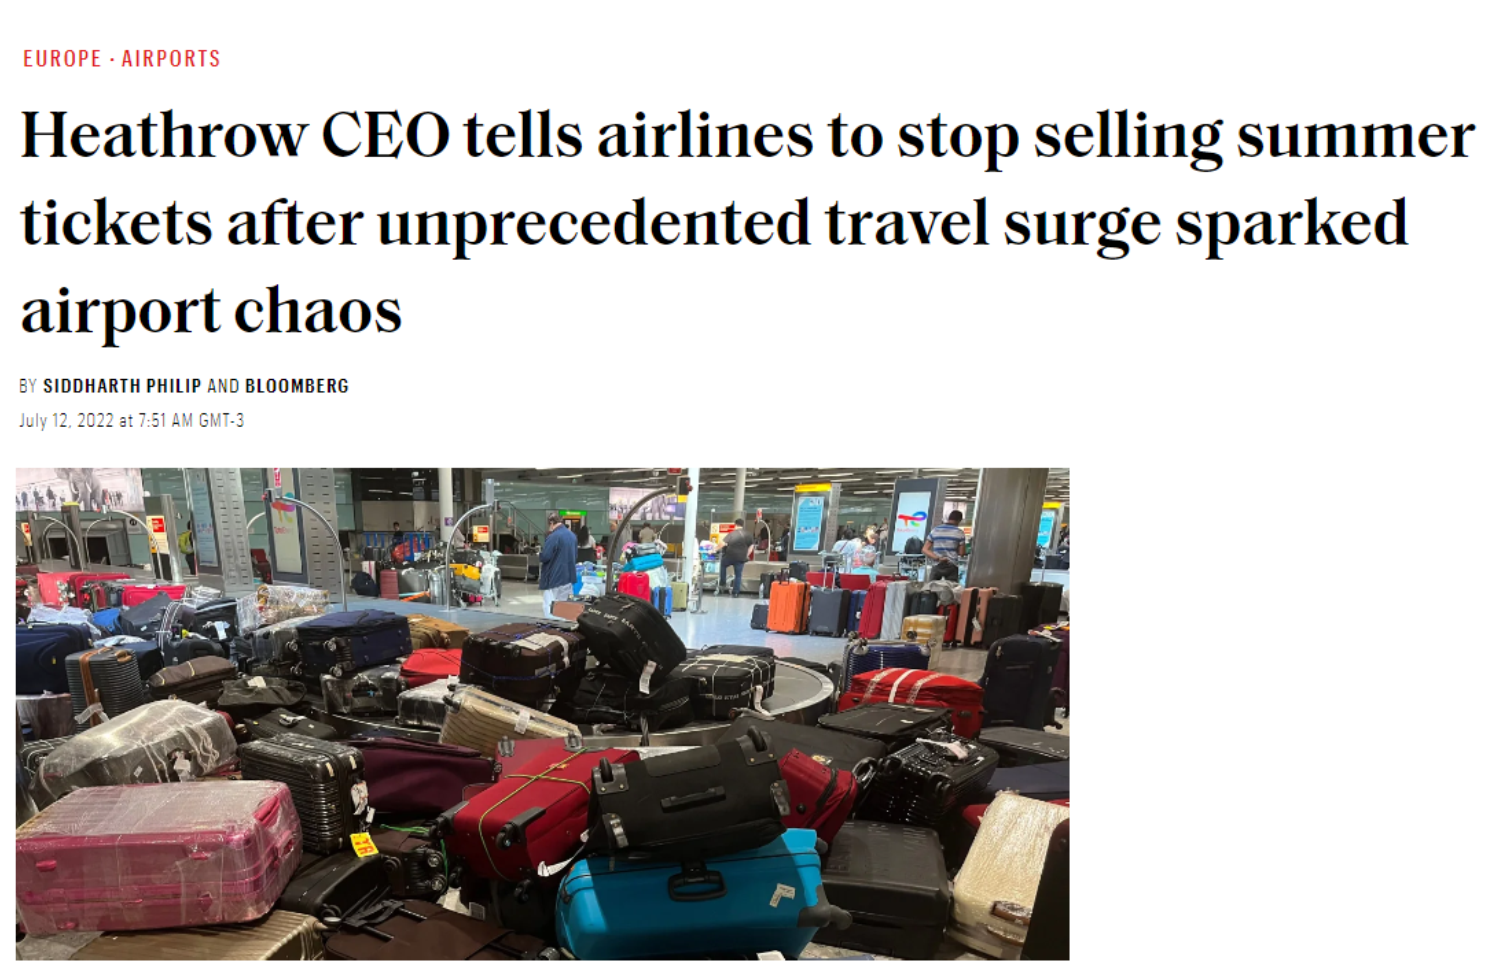
## Retrieve and visualize the data

# Retrieve and visualize the data

In [ ]:
import numpy
import math
import matplotlib.pyplot as plt
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
 
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Text(0.5, 1.0, 'Scaled training dataset')

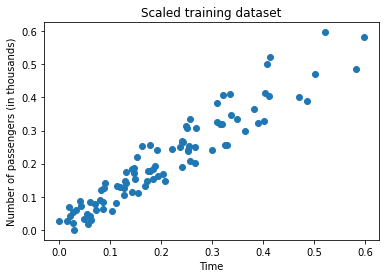

In [ ]:
#Visualize the train dataset
flat_list = [item for sublist in trainX.tolist() for item in sublist]
flat_list_x = [item for sublist in flat_list for item in sublist]

plt.scatter(flat_list_x,trainY)
plt.xlabel("Time")
plt.ylabel("Number of passengers (in thousands)")
plt.title("Scaled training dataset")


# Train a LSTM

Let's train a LSTM with 4 hidden units using the first 60% of the dates. We'll use the trained LSTM to predict the number of passengers in the last third of the data.

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1,verbose=0)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY_inv = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_inv = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_inv[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_inv[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.77 RMSE
Test Score: 48.54 RMSE


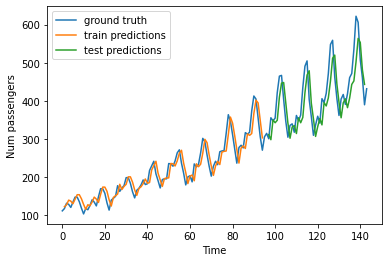

In [ ]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions

fig = plt.figure()

plt.plot(scaler.inverse_transform(dataset),label="ground truth")
plt.plot(trainPredictPlot,label="train predictions")
plt.plot(testPredictPlot,label="test predictions")
plt.xlabel("Time")
plt.ylabel("Num passengers")

plt.legend(loc='upper left')

# Bonus: Impact of the number of hidden cells
Let's analyse how the number of hidden cells impacts the test error:

In [ ]:
trainScores = {}
testScores = {}
param_grid =  range(1,100,2)
REPETITIONS = 8

for number_of_lstm_units in param_grid:
  trainScores[number_of_lstm_units] = []
  testScores[number_of_lstm_units] =  []

for i in range(1,REPETITIONS):
  for number_of_lstm_units in param_grid:
    model = Sequential()
    model.add(LSTM(number_of_lstm_units, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=150, batch_size=5, verbose=0)

    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY_inv = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY_inv = scaler.inverse_transform([testY])
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY_inv[0], trainPredict[:,0]))
    testScore = math.sqrt(mean_squared_error(testY_inv[0], testPredict[:,0]))
    trainScores[number_of_lstm_units] = trainScores[number_of_lstm_units] + [trainScore]
    testScores[number_of_lstm_units] =  testScores[number_of_lstm_units] + [testScore]


Text(0, 0.5, 'RMSE in test')

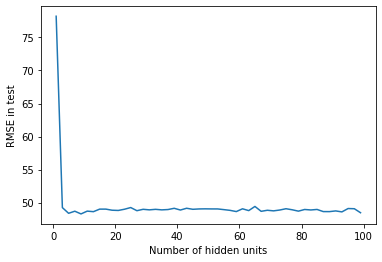

In [ ]:
plt.plot(list(param_grid),  [ sum(x)/len(x) for x in list(testScores.values())])
plt.xlabel("Number of hidden units")
plt.ylabel("RMSE in test")

As we can see, the error goes down quickly as we add the first ~5 hidden units. From then on, adding more hidden units does not seem to provide much benefit.

Training once for each configuration generated a very noise curve, so I averaged the results of 8 repetitions in order to get a smooth curve.